In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from skgstat import Variogram, OrdinaryKriging
from pykrige.uk import UniversalKriging
import geopandas as geopd
import contextily as ctx
import shapely as shp
import cartopy

In [2]:
#Einlesen des Datensatzes 
header = ['GW-Nummer','Stadt','Lat','Lon']
pegel   = pd.read_csv("Pegel_data.csv",sep=";",encoding='cp1252', names=header)
depth   = pd.read_csv("GW_depth.csv",delimiter=',')
data = pd.merge(pegel,depth,how='left', on='GW-Nummer')
data = data.groupby("GW-Nummer").mean()
data =data.dropna()
data.columns = ['Lat','Lon', 'GWHoehe']

In [7]:
#Einlesen der Pegeldaten, um Shape Datei zu erstellen
header = ['GW-Nummer','Stadt','Lat','Lon']
df = pd.read_csv('Pegel_data.csv',sep=';', encoding='cp1252', names=header)

#Geometrien erstellen
geometry =[]
for index, row in df.iterrows():
    geometry.append(shp.geometry.Point(row.Lon, row.Lat))
    
#Ins geopandas Format speichern
gdf = geopd.GeoDataFrame(df, crs='epsg:4326', geometry=geometry)

#speichern als Shape-Datei
gdf.to_file('Pegel_data.shp')

#öffnen der Shape-Datei
monitoring = geopd.read_file('Pegel_data.shp')

/Users/markvollmer/opt/anaconda3/envs/geo/lib/python3.7/site-packages/skgstat/plotting/variogram_plot.py:96: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


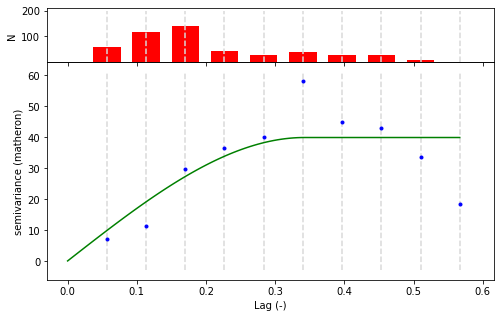

In [8]:
# Zur Visualisierung der Semivarianz wird ein Variogram-Objekt erzeugt 
Var = Variogram(data[['Lon', 'Lat']].values, data.GWHoehe)
Var.plot();

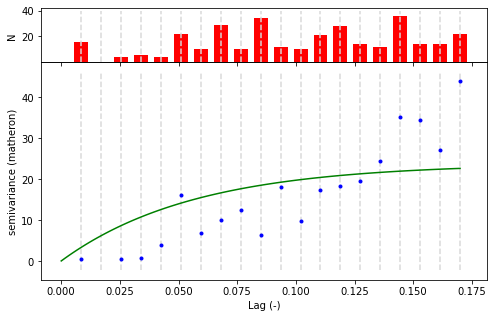

In [12]:
#Größe der Lags werden reduziert, um Werte im Bereich, der mit Daten unterstüzt wird, besser darzustellen
Var.maxlag = 0.3
Var.n_lags = 20
Var.plot(show=False);

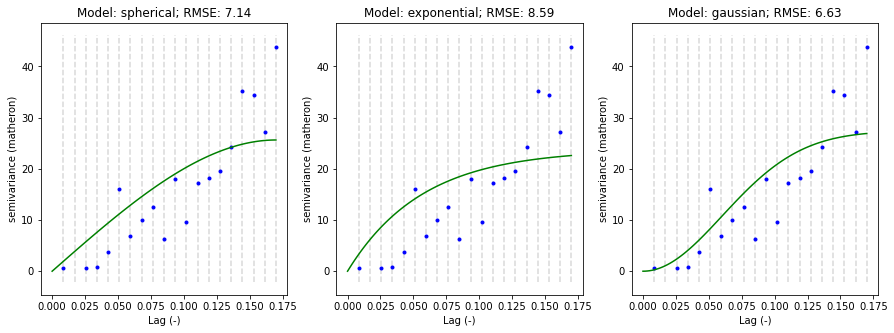

In [13]:
#plotten von anderen Modellen zum vergleichen mit RMSE 
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
Var.model = 'spherical'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('spherical', Var.rmse))

ax = axs[1]
Var.model = 'exponential'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('exponential', Var.rmse))

ax = axs[2]
Var.model = 'gaussian'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('gaussian', Var.rmse))
plt.show()

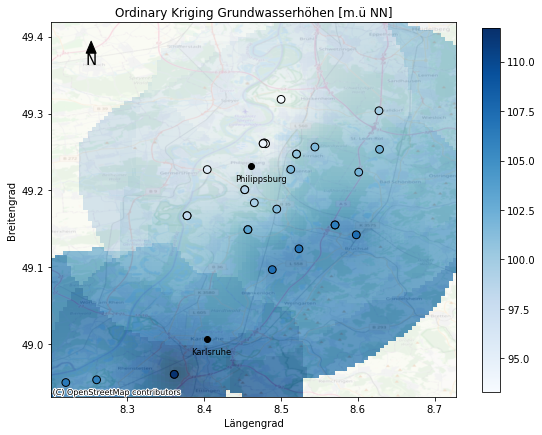

In [14]:
#Auswahl des passenste Variogramm-Modell und Durchführung eines Ordinary Kriging
#(Trotz größtem RMSE-Wert gab es beim exponential model die besten Ergebnisse)

Var.model = 'exponential'
ok = OrdinaryKriging(Var, min_points=2, max_points=8)

extent = x_min, x_max, y_min, y_max = [data.Lon.min(), data.Lon.max()+0.1,
                                       data.Lat.min(), data.Lat.max()+0.1]
grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

field = ok.transform(grid_x.flatten(), grid_y.flatten()).reshape(grid_x.shape)

fig = plt.figure(1, figsize=(20,10))
ax = fig.add_subplot(1,2,1)
c1 = ax.imshow(field.T, origin='lower', extent=extent, cmap='Blues')
c2 = plt.scatter(data.Lon, data.Lat, s=60, c=data.GWHoehe, edgecolor='k',  cmap = 'Blues')
ctx.add_basemap(ax, crs=monitoring.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.3)

#Nordpfeil in die Karte 
x, y, arrow_length = 0.1, 0.95, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=2.5, headwidth=10),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)
def plot_cities(ax):
    lats = [49.006889,49.2317]
    lons = [8.403653, 8.46074]
    cities = ['Karlsruhe','Philippsburg']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'o',color='k',zorder=1)
        ax.text(lon-0.02, lat-0.02 , city, fontsize='small')
plot_cities(ax)
ax.set_title('Ordinary Kriging Grundwasserhöhen [m.ü NN]')
plt.xlabel('Längengrad')
plt.ylabel('Breitengrad')
plt.colorbar(c1, shrink=0.67)

In [23]:
#Drop der Duplikate im Datensatz
data= data.drop_duplicates('Lat')

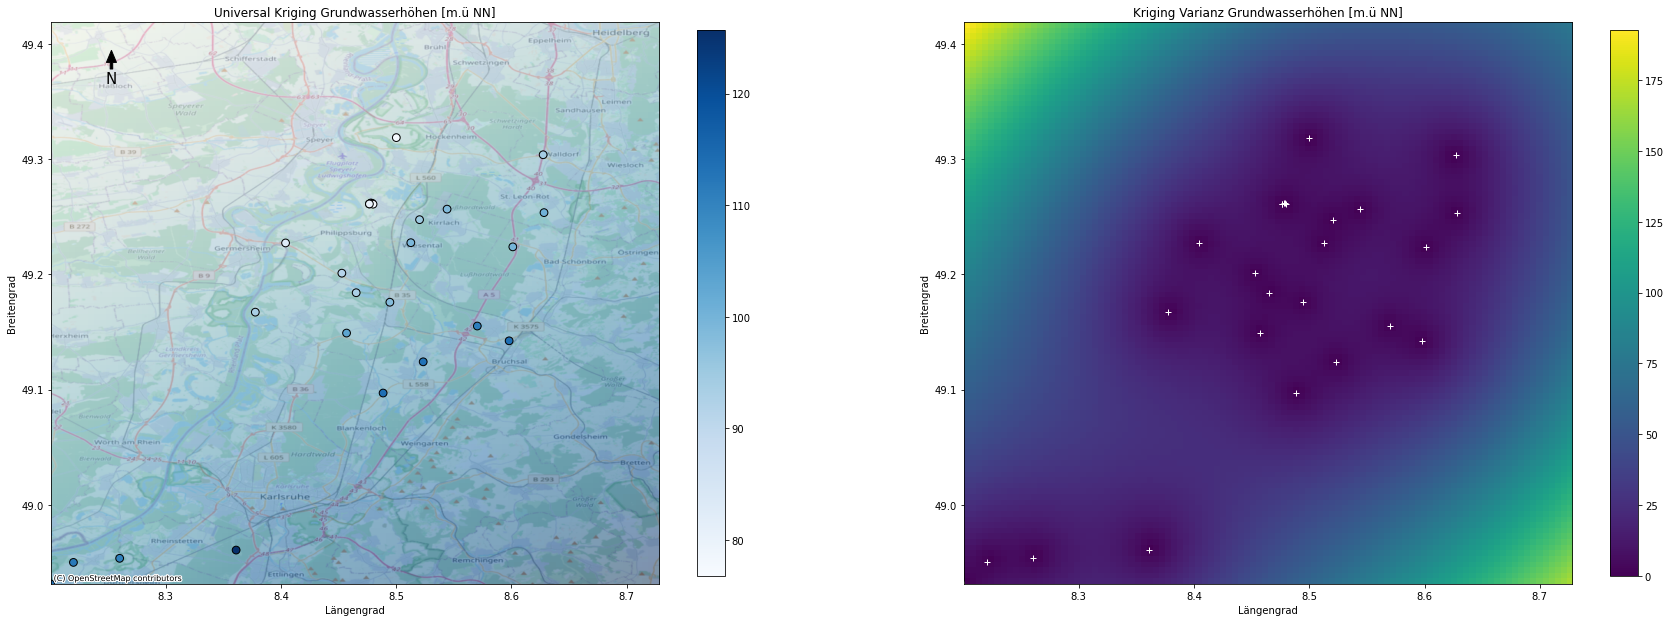

In [35]:
#Auswahl des passenste Variogramm-Modell und Durchführung eines Universag Kriging mit Varianz
UK = UniversalKriging(data.Lon, data.Lat, data.GWHoehe,
                      variogram_model="exponential", drift_terms=["regional_linear"])

#Interpolation des Grid
z, ss = UK.execute("points", grid_x.flatten(), grid_y.flatten())
z = z.reshape(grid_x.shape)
ss = ss.reshape(grid_x.shape)

fig = plt.figure(1, figsize=(30, 15))
ax = fig.add_subplot(1,2,1)
c1 = ax.imshow(z.T, origin='lower', extent=extent, cmap='Blues')
c2 = plt.scatter(data.Lon, data.Lat, s=60, c=data.GWHoehe, edgecolor='k',  cmap = 'Blues')
ctx.add_basemap(ax, crs=monitoring.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.3)

#Nordpfeil in die Karte 
x, y, arrow_length = 0.1, 0.95, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=2.5, headwidth=10),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

ax.set_title('Universal Kriging Grundwasserhöhen [m.ü NN]')
plt.xlabel('Längengrad')
plt.ylabel('Breitengrad')
plt.colorbar(c1, shrink=0.67)

#Kriging Varianz plotten
ax1 = fig.add_subplot(1,2,2)
art2 = ax1.imshow(ss.T, origin='lower', extent=extent, cmap='viridis')
ax1.plot(data.Lon, data.Lat, '+w')
ax1.set_title('Kriging Varianz Grundwasserhöhen [m.ü NN]')
plt.colorbar(art2, shrink=0.67)
ctx.add_basemap(ax, crs=monitoring.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.3)
plt.xlabel('Längengrad')
plt.ylabel('Breitengrad')
plt.show()